# Used Cars Analysis - Scraping, Cleaning & Visual Analysis
## by Andy Pang

Used car data is pulled from vroom.com using BeautifulSoup and Selenium. In this notebook, the scraped raw data is cleaned/prepared and exploratory analysis is performed. Predictive modeling on used car prices will be implemented using the CSV file generated from this notebook. Various methods such as multivariate linear regression, decision trees, and ridge/lasso regression will be explored upon and compared in R.

In [184]:
from bs4 import BeautifulSoup as BS
from requests import get
#from requests_html import AsyncHTMLSession
from time import sleep
import urllib.request
import pandas as pd
import numpy as np
import re
#import asyncio
#import nest_asyncio
#nest_asyncio.apply()
from selenium import webdriver
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.common.exceptions import TimeoutException

import matplotlib.pyplot as plt
import seaborn as sns

In [52]:
agent = "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/42.0.2311.135 Safari/537.36 Edge/12.246"

In [53]:
head={}
head["User-Agent"]=agents
head["referrer"]="https://www.google.com"
head["Dnt"]= "1" 
head['Connection']= 'keep-alive'
head["Upgrade-Insecure-Requests"]= "1"

In [ ]:
#pulling multiple pages -> storing links
url = "https://www.vroom.com/cars"
linkslist=[]
p = 1
t = 60
delay=10 #s
browser = webdriver.Chrome(r"C:\Users\A\Desktop\carproject\chromedriver.exe")

while True:
    if p > t: break
    browser.get(url)
    #data load
    WebDriverWait(browser,delay)
    html=browser.page_source
    lsoup = BS(html,'lxml')
    for each in lsoup.find_all("a",{"class":"jss1003"},href=True):
        link = "https://www.vroom.com"+each["href"]
        linkslist.append(link)
    p += 1
    browser.find_element(By.XPATH,"//button[@aria-label='Go to next page']").click()
    url = browser.current_url
linkslist
#len(linkslist) list of 1440 cars, now we pull data from each link

In order to run the code above to scrape the Javascript content from the site, the ChromeDriver from Google is needed. It can be found at:
https://sites.google.com/a/chromium.org/chromedriver/home

In [125]:
#general case: https://www.vroom.com/inventory/volkswagen-tiguan-2019-3VV3B7AX2KM198822
#no mpg: https://www.vroom.com/inventory/hyundai-accent-2019-3KPC24A36KE076484
#sale pending: https://www.vroom.com/inventory/ford-edge-2015-2FMTK3J86FBB34933
#sale pending no mpg: https://www.vroom.com/inventory/nissan-versa-2018-3N1CN7AP7JL865705
delays = [8,2,4,23,15,10,20,18,17,9,10,11,14,12,13]
data = pd.DataFrame(columns=["name","mileage","price","owners","body","int","ext",
                             "vin","engine","tm","drive","fuel","mpg","height","length","width","gclear","wheelb","ftrackw","rtrackw"])

for each in linkslist:
    delay = np.random.choice(delays)
    sleep(delay)
    cget = get((each),headers=head)
    csoup = BS(cget.text,"lxml")
    
    car = {}
    if csoup.find("p",{"class":"MuiBox-root jss260 jss25 jss28 jss258 jss259"}) is None: #then pendingsale
        if csoup.find("p",{"class":"MuiBox-root jss313 jss25 jss28 jss291 jss312"}) is None: #then pendingsalenompg
            #pendingsalenompg
            car["name"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[1].text
            car["mileage"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[2].text
            car["price"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[3].text
            car["owners"]=csoup.find("div",{"class":"jss217 jss218"}).find("span",{"class":"bold"}).text
            car["body"]=csoup.find("p",{"class":"MuiBox-root jss265 jss25 jss28 jss263 jss264"}).text
            car["int"]=csoup.find("p",{"class":"MuiBox-root jss270 jss25 jss28 jss263 jss269"}).text #NEED TO CLEAN
            car["ext"]=csoup.find("p", {"class":"MuiBox-root jss275 jss25 jss28 jss263 jss274"}).text
            car["vin"]=csoup.find("p",{"class":"MuiBox-root jss280 jss25 jss28 jss263 jss279"}).text
            car["engine"]=csoup.find("p",{"class":"MuiBox-root jss293 jss25 jss28 jss291 jss292"}).text
            car["tm"]=csoup.find("p",{"class":"MuiBox-root jss298 jss25 jss28 jss291 jss297"}).text
            car["drive"]=csoup.find("p",{"class":"MuiBox-root jss303 jss25 jss28 jss291 jss302"}).text
            car["fuel"]=csoup.find("p",{"class":"MuiBox-root jss308 jss25 jss28 jss291 jss307"}).text
            car["mpg"]=np.nan
            car["height"]=csoup.find("p",{"class":"MuiBox-root jss324 jss25 jss28 jss322 jss323"}).text
            car["length"]=csoup.find("p",{"class":"MuiBox-root jss329 jss25 jss28 jss322 jss328"}).text
            car["width"]=csoup.find("p",{"class":"MuiBox-root jss334 jss25 jss28 jss322 jss333"}).text
            car["gclear"]=csoup.find("p",{"class":"MuiBox-root jss339 jss25 jss28 jss322 jss338"}).text #ground clearance
            car["wheelb"]=csoup.find("p",{"class":"MuiBox-root jss344 jss25 jss28 jss322 jss343"}).text #wheelbase
            car["ftrackw"]=csoup.find("p",{"class":"MuiBox-root jss349 jss25 jss28 jss322 jss348"}).text #front track width
            car["rtrackw"]=csoup.find("p",{"class":"MuiBox-root jss354 jss25 jss28 jss322 jss353"}).text #rear track width
            data=data.append(car,ignore_index=True)
            continue
        else:
            #pendingsale
            car["name"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[1].text
            car["mileage"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[2].text
            car["price"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[3].text
            car["owners"]=csoup.find("div",{"class":"jss217 jss218"}).find("span",{"class":"bold"}).text
            car["body"]=csoup.find("p",{"class":"MuiBox-root jss265 jss25 jss28 jss263 jss264"}).text
            car["int"]=csoup.find("p",{"class":"MuiBox-root jss270 jss25 jss28 jss263 jss269"}).text #NEED TO CLEAN
            car["ext"]=csoup.find("p", {"class":"MuiBox-root jss275 jss25 jss28 jss263 jss274"}).text
            car["vin"]=csoup.find("p",{"class":"MuiBox-root jss280 jss25 jss28 jss263 jss279"}).text
            car["engine"]=csoup.find("p",{"class":"MuiBox-root jss293 jss25 jss28 jss291 jss292"}).text
            car["tm"]=csoup.find("p",{"class":"MuiBox-root jss298 jss25 jss28 jss291 jss297"}).text
            car["drive"]=csoup.find("p",{"class":"MuiBox-root jss303 jss25 jss28 jss291 jss302"}).text
            car["fuel"]=csoup.find("p",{"class":"MuiBox-root jss308 jss25 jss28 jss291 jss307"}).text
            car["mpg"]=csoup.find("p",{"class":"MuiBox-root jss313 jss25 jss28 jss291 jss312"}).text #need to split city and highway
            car["height"]=csoup.find("p",{"class":"MuiBox-root jss329 jss25 jss28 jss327 jss328"}).text
            car["length"]=csoup.find("p",{"class":"MuiBox-root jss334 jss25 jss28 jss327 jss333"}).text
            car["width"]=csoup.find("p",{"class":"MuiBox-root jss339 jss25 jss28 jss327 jss338"}).text
            car["gclear"]=csoup.find("p",{"class":"MuiBox-root jss344 jss25 jss28 jss327 jss343"}).text #ground clearance
            car["wheelb"]=csoup.find("p",{"class":"MuiBox-root jss349 jss25 jss28 jss327 jss348"}).text #wheelbase
            car["ftrackw"]=csoup.find("p",{"class":"MuiBox-root jss354 jss25 jss28 jss327 jss353"}).text #front track width
            car["rtrackw"]=csoup.find("p",{"class":"MuiBox-root jss359 jss25 jss28 jss327 jss358"}).text #rear track width
            data=data.append(car,ignore_index=True)
            continue
    if csoup.find("p",{"class":"MuiBox-root jss308 jss25 jss28 jss286 jss307"}) is None: #then nompg
        car["name"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[0].text
        car["mileage"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[1].text
        car["price"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[2].text
        car["owners"]=csoup.find("div",{"class":"jss217 jss218"}).find("span",{"class":"bold"}).text
        car["body"]=csoup.find("p",{"class":"MuiBox-root jss260 jss25 jss28 jss258 jss259"}).text
        car["int"]=csoup.find("p",{"class":"MuiBox-root jss265 jss25 jss28 jss258 jss264"}).text #NEED TO CLEAN
        car["ext"]=csoup.find("p", {"class":"MuiBox-root jss270 jss25 jss28 jss258 jss269"}).text
        car["vin"]=csoup.find("p",{"class":"MuiBox-root jss275 jss25 jss28 jss258 jss274"}).text
        car["engine"]=csoup.find("p",{"class":"MuiBox-root jss288 jss25 jss28 jss286 jss287"}).text
        car["tm"]=csoup.find("p",{"class":"MuiBox-root jss293 jss25 jss28 jss286 jss292"}).text
        car["drive"]=csoup.find("p",{"class":"MuiBox-root jss298 jss25 jss28 jss286 jss297"}).text
        car["fuel"]=csoup.find("p",{"class":"MuiBox-root jss303 jss25 jss28 jss286 jss302"}).text
        car["mpg"]=np.nan
        car["height"]=csoup.find("p",{"class":"MuiBox-root jss319 jss25 jss28 jss317 jss318"}).text
        car["length"]=csoup.find("p",{"class":"MuiBox-root jss324 jss25 jss28 jss317 jss323"}).text
        car["width"]=csoup.find("p",{"class":"MuiBox-root jss329 jss25 jss28 jss317 jss328"}).text
        car["gclear"]=csoup.find("p",{"class":"MuiBox-root jss334 jss25 jss28 jss317 jss333"}).text #ground clearance
        car["wheelb"]=csoup.find("p",{"class":"MuiBox-root jss339 jss25 jss28 jss317 jss338"}).text #wheelbase
        car["ftrackw"]=csoup.find("p",{"class":"MuiBox-root jss344 jss25 jss28 jss317 jss343"}).text #front track width
        car["rtrackw"]=csoup.find("p",{"class":"MuiBox-root jss349 jss25 jss28 jss317 jss348"}).text #rear track width    
        data=data.append(car,ignore_index=True)
        continue
    else: 
        #normal
        car["name"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[0].text
        car["mileage"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[1].text
        car["price"]=csoup.find("div",{"class":"jss155 jss156"}).find_all("p")[2].text
        car["owners"]=csoup.find("div",{"class":"jss217 jss218"}).find("span",{"class":"bold"}).text
        car["body"]=csoup.find("p",{"class":"MuiBox-root jss260 jss25 jss28 jss258 jss259"}).text
        car["int"]=csoup.find("p",{"class":"MuiBox-root jss265 jss25 jss28 jss258 jss264"}).text #NEED TO CLEAN
        car["ext"]=csoup.find("p", {"class":"MuiBox-root jss270 jss25 jss28 jss258 jss269"}).text
        car["vin"]=csoup.find("p",{"class":"MuiBox-root jss275 jss25 jss28 jss258 jss274"}).text
        car["engine"]=csoup.find("p",{"class":"MuiBox-root jss288 jss25 jss28 jss286 jss287"}).text
        car["tm"]=csoup.find("p",{"class":"MuiBox-root jss293 jss25 jss28 jss286 jss292"}).text
        car["drive"]=csoup.find("p",{"class":"MuiBox-root jss298 jss25 jss28 jss286 jss297"}).text
        car["fuel"]=csoup.find("p",{"class":"MuiBox-root jss303 jss25 jss28 jss286 jss302"}).text
        car["mpg"]=csoup.find("p",{"class":"MuiBox-root jss308 jss25 jss28 jss286 jss307"}).text #need to split city and highway
        car["height"]=csoup.find("p",{"class":"MuiBox-root jss324 jss25 jss28 jss322 jss323"}).text
        car["length"]=csoup.find("p",{"class":"MuiBox-root jss329 jss25 jss28 jss322 jss328"}).text
        car["width"]=csoup.find("p",{"class":"MuiBox-root jss334 jss25 jss28 jss322 jss333"}).text
        car["gclear"]=csoup.find("p",{"class":"MuiBox-root jss339 jss25 jss28 jss322 jss338"}).text #ground clearance
        car["wheelb"]=csoup.find("p",{"class":"MuiBox-root jss344 jss25 jss28 jss322 jss343"}).text #wheelbase
        car["ftrackw"]=csoup.find("p",{"class":"MuiBox-root jss349 jss25 jss28 jss322 jss348"}).text #front track width
        car["rtrackw"]=csoup.find("p",{"class":"MuiBox-root jss354 jss25 jss28 jss322 jss353"}).text #rear track width
        data=data.append(car,ignore_index=True)

Here, the data is successfully collected. I have saved a copy of this data so that the webscraping portion does not have to be performed again. 

In [171]:
data.shape

(1440, 20)

In [219]:
cna = data.dropna(axis=0) #remove rows with missing values
cna.shape

(1124, 20)

In [295]:
unav = cna.index[cna.stack().str.contains("Unavailable").any(level=0)] #remove rows with missing "unavailable" values
cu = cna.drop(index=unav)
cu.reset_index(inplace=True)
cu.shape

(877, 21)

In [200]:
cu.head(10)

,Unnamed: 0,name,mileage,price,owners,body,int,ext,vin,engine,...,drive,fuel,height,length,width,gclear,wheelb,ftrackw,mpg,rtrackw
0,0,2016 Honda CR-V,"SE | 25,357 miles","$18,400",1,SUV,Tan,Mountain Air Metallic,2HKRM3H47GH527308,2.4L I4 185hp 181ft. lbs.,...,FWD,Gasoline,"64.7""","179.4""","71.6""","6.3""","103.1""","62.1""",26 City / 33 Hwy,"62.2"""
1,1,2017 INFINITI QX60,"Base | 21,296 miles","$27,500",1,SUV,Black,Liquid Platinum,5N1DL0MN2HC557545,3.5L V6 295hp 270ft. lbs.,...,FWD,Gasoline,"68.6""","200.1""","77.2""","6.5""","114.2""","65.7""",20 City / 27 Hwy,"65.7"""
2,2,2018 Buick Encore,"Preferred | 16,428 miles","$16,600",1,SUV,Black,White,KL4CJASB6JB707473,Ecotec 1.4L Turbo I4 138hp 148ft. lbs.,...,FWD,Gasoline,"65.3""","168.4""","69.9""","6.2""","100.6""","60.6""",27 City / 33 Hwy,"60.6"""
3,3,2018 Nissan Kicks,"SV | 14,324 miles","$16,700",1,SUV,Black,Gun Metallic,3N1CP5CUXJL513994,1.6L I4 125hp 115ft. lbs.,...,FWD,Gasoline,"62.4""","169.1""","69.3""","7""","103.1""","59.8""",31 City / 36 Hwy,"60.4"""
4,4,2016 Ford Explorer,"XLT | 49,463 miles","$21,000",2,SUV,Black,White,1FM5K7DH9GGB29960,EcoBoost 2.3L Turbo I4 280hp 310ft. lbs.,...,FWD,Gasoline,"70""","198.3""","90.2""","7.8""","112.8""","67""",19 City / 28 Hwy,"67"""
5,6,2017 Lexus NX 200t,"Base | 21,265 miles","$28,280",1,Wagon,Black,White,JTJYARBZ7H2082080,2.0L Turbo I4 235hp 258ft. lbs.,...,FWD,Gasoline,"64.8""","182.3""","83.9""","6.9""","104.7""","62.2""",22 City / 28 Hwy,"62.2"""
6,7,2020 Volkswagen Passat,"2.0T R-Line | 1,390 miles","$23,980",1,Sedan,Black,Red,1VWMA7A39LC014107,2.0L Turbo I4 174hp 206ft. lbs.,...,FWD,Gasoline,"58""","193.6""","72.2""","5.4""","110.4""","62.1""",23 City / 34 Hwy,"61"""
7,8,2019 BMW 5 Series,"530i | 9,819 miles","$39,900",1,Sedan,Black,White,WBAJA5C58KWW08559,2.0L Turbo I4 248hp 258ft. lbs.,...,RWD,Gasoline,"58.2""","194.6""","83.7""","5.7""","117.1""","63""",24 City / 34 Hwy,"64.2"""
8,10,2019 Dodge Grand Caravan,"SXT | 9,194 miles","$20,140",1,Van Minivan,Black,Octane Red Pearl Coat,2C4RDGCG7KR641751,Pentastar 3.6L Flex Fuel V6 283hp 260ft. lbs.,...,FWD,Flex Fuel,"69""","203.7""","88.5""","5.8""","121.2""","65.6""",12 City / 18 Hwy,"64.8"""
9,11,2017 Kia Optima Hybrid,"EX | 15,898 miles","$18,000",1,Sedan,Black,Aurora Black,KNAGU4LC0H5007610,2.0L Hybrid I4 192hp 271ft. lbs.,...,FWD,Gas/Electric Hybrid,"57.5""","191.1""","73.2""","5.1""","110""","63""",39 City / 46 Hwy,"64"""


I closed the Jupyter kernel at some point and lost all my variables on this notebook. Good thing I exported the data to a csv file some point earlier. The code below will read in the 'cu' dataframe.

In [201]:
cu = pd.read_csv("C:/Users/A/Desktop/carproject/cu.csv")
cu.head(10)

,Unnamed: 0,name,mileage,price,owners,body,int,ext,vin,engine,...,drive,fuel,height,length,width,gclear,wheelb,ftrackw,mpg,rtrackw
0,0,2016 Honda CR-V,"SE | 25,357 miles","$18,400",1,SUV,Tan,Mountain Air Metallic,2HKRM3H47GH527308,2.4L I4 185hp 181ft. lbs.,...,FWD,Gasoline,"64.7""","179.4""","71.6""","6.3""","103.1""","62.1""",26 City / 33 Hwy,"62.2"""
1,1,2017 INFINITI QX60,"Base | 21,296 miles","$27,500",1,SUV,Black,Liquid Platinum,5N1DL0MN2HC557545,3.5L V6 295hp 270ft. lbs.,...,FWD,Gasoline,"68.6""","200.1""","77.2""","6.5""","114.2""","65.7""",20 City / 27 Hwy,"65.7"""
2,2,2018 Buick Encore,"Preferred | 16,428 miles","$16,600",1,SUV,Black,White,KL4CJASB6JB707473,Ecotec 1.4L Turbo I4 138hp 148ft. lbs.,...,FWD,Gasoline,"65.3""","168.4""","69.9""","6.2""","100.6""","60.6""",27 City / 33 Hwy,"60.6"""
3,3,2018 Nissan Kicks,"SV | 14,324 miles","$16,700",1,SUV,Black,Gun Metallic,3N1CP5CUXJL513994,1.6L I4 125hp 115ft. lbs.,...,FWD,Gasoline,"62.4""","169.1""","69.3""","7""","103.1""","59.8""",31 City / 36 Hwy,"60.4"""
4,4,2016 Ford Explorer,"XLT | 49,463 miles","$21,000",2,SUV,Black,White,1FM5K7DH9GGB29960,EcoBoost 2.3L Turbo I4 280hp 310ft. lbs.,...,FWD,Gasoline,"70""","198.3""","90.2""","7.8""","112.8""","67""",19 City / 28 Hwy,"67"""
5,6,2017 Lexus NX 200t,"Base | 21,265 miles","$28,280",1,Wagon,Black,White,JTJYARBZ7H2082080,2.0L Turbo I4 235hp 258ft. lbs.,...,FWD,Gasoline,"64.8""","182.3""","83.9""","6.9""","104.7""","62.2""",22 City / 28 Hwy,"62.2"""
6,7,2020 Volkswagen Passat,"2.0T R-Line | 1,390 miles","$23,980",1,Sedan,Black,Red,1VWMA7A39LC014107,2.0L Turbo I4 174hp 206ft. lbs.,...,FWD,Gasoline,"58""","193.6""","72.2""","5.4""","110.4""","62.1""",23 City / 34 Hwy,"61"""
7,8,2019 BMW 5 Series,"530i | 9,819 miles","$39,900",1,Sedan,Black,White,WBAJA5C58KWW08559,2.0L Turbo I4 248hp 258ft. lbs.,...,RWD,Gasoline,"58.2""","194.6""","83.7""","5.7""","117.1""","63""",24 City / 34 Hwy,"64.2"""
8,10,2019 Dodge Grand Caravan,"SXT | 9,194 miles","$20,140",1,Van Minivan,Black,Octane Red Pearl Coat,2C4RDGCG7KR641751,Pentastar 3.6L Flex Fuel V6 283hp 260ft. lbs.,...,FWD,Flex Fuel,"69""","203.7""","88.5""","5.8""","121.2""","65.6""",12 City / 18 Hwy,"64.8"""
9,11,2017 Kia Optima Hybrid,"EX | 15,898 miles","$18,000",1,Sedan,Black,Aurora Black,KNAGU4LC0H5007610,2.0L Hybrid I4 192hp 271ft. lbs.,...,FWD,Gas/Electric Hybrid,"57.5""","191.1""","73.2""","5.1""","110""","63""",39 City / 46 Hwy,"64"""


In [3]:
#cleaning
cars=pd.DataFrame()
#cul = cu.drop(np.where(cu['engine'].str.extract(r'(\S*L)').isnull()==True)[0])#dropping cars w/ missing displacement
#engine displacement not a good predictor of engine power...
#cars with missing displacement -> electric
cut = cu.drop(np.where(cu['engine'].str.extract(r'(\s.{3}ft. lbs.)').isnull()==True)[0])#dropping cars w/ missing torque -> 8 cars
names = cut.name.str.split(n=2,expand = True)
cars['year'] = pd.to_numeric(names[0]) # added year of car as int
cars['make'] = names[1] #added make of car as str
miles = cut.mileage.str.split().str[-2]
cars['miles'] = pd.to_numeric(miles.apply(lambda x:x.replace(',',''))) #added mileage as int
cost = cut.price
cost = cost.apply(lambda x:x.replace(',',''))
cost = cost.apply(lambda x:x.replace('$',''))
cars['price'] = pd.to_numeric(cost)
cars['owners'] = pd.to_numeric(cut.owners)
cars['body']=cut.body
cars['interior']=cut.int
cars['exterior']=cut.ext
#cars['Edisplace']=pd.to_numeric(cut.engine.str.extract(r'(\S*L)')[0].str.rstrip('L')) # engine displacement in L
cars['hp']=pd.to_numeric(cut.engine.str.extract(r'(.*hp)')[0].str.split().str[-1].str.strip('hp')) #horsepower
cars['torque']=pd.to_numeric(cut.engine.str.extract(r'(\s.{3}ft. lbs.)')[0].str[:4])
cars['tm']=cut['tm']
cars['drive']=cut['drive'].str.upper()
cars['fuel']=cut['fuel']
cars['height']=pd.to_numeric(cut["height"].str[:-1])
cars['length']=pd.to_numeric(cut["length"].str[:-1])
cars['width']=pd.to_numeric(cut["width"].str[:-1])
cars['gclear']=pd.to_numeric(cut["gclear"].str[:-1])
cars['wheelb']=pd.to_numeric(cut["wheelb"].str[:-1])
cars['ftrackw']=pd.to_numeric(cut["ftrackw"].str[:-1])
cars['rtrackw']=pd.to_numeric(cut["rtrackw"].str[:-1])
mpgs = cut["mpg"].str.split('/',expand=True)
cars['cmpg'] = pd.to_numeric(mpgs[0].str.split(expand=True)[0]) #city mpg
cars['hmpg'] = pd.to_numeric(mpgs[1].str.split(expand=True)[0]) #highway mpg
cars

,year,make,miles,price,owners,body,interior,exterior,hp,torque,...,fuel,height,length,width,gclear,wheelb,ftrackw,rtrackw,cmpg,hmpg
0,2016,Honda,25357,18400,1,SUV,Tan,Mountain Air Metallic,185,181,...,Gasoline,64.7,179.4,71.6,6.3,103.1,62.1,62.2,26,33
1,2017,INFINITI,21296,27500,1,SUV,Black,Liquid Platinum,295,270,...,Gasoline,68.6,200.1,77.2,6.5,114.2,65.7,65.7,20,27
2,2018,Buick,16428,16600,1,SUV,Black,White,138,148,...,Gasoline,65.3,168.4,69.9,6.2,100.6,60.6,60.6,27,33
3,2018,Nissan,14324,16700,1,SUV,Black,Gun Metallic,125,115,...,Gasoline,62.4,169.1,69.3,7.0,103.1,59.8,60.4,31,36
4,2016,Ford,49463,21000,2,SUV,Black,White,280,310,...,Gasoline,70.0,198.3,90.2,7.8,112.8,67.0,67.0,19,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
871,2016,Toyota,26578,32500,1,SUV,Black,Ooh La La Rouge Mica,270,248,...,Gasoline,70.1,191.1,75.8,8.0,109.8,64.4,64.2,18,24
872,2018,Volkswagen,13902,28150,2,SUV,Tan,Red,276,266,...,Gasoline,70.0,198.3,78.3,8.0,117.3,67.2,67.8,18,25
874,2019,Hyundai,10918,19780,1,Hatchback,Black,Ceramic White,118,218,...,Electric,57.1,176.0,71.7,5.5,106.3,61.2,61.8,150,122
875,2018,Lexus,13277,41810,1,SUV,Black,Nebula Gray Pearl,295,267,...,Gasoline,67.7,192.5,74.6,8.2,109.8,64.4,64.0,19,26


In [4]:
cars.describe()

,year,miles,price,owners,hp,torque,height,length,width,gclear,wheelb,ftrackw,rtrackw,cmpg,hmpg
count,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000,869.000000
mean,2018.234753,26660.696203,25738.642117,1.094361,249.348677,250.881473,65.942854,189.304488,78.230495,7.121404,111.697468,63.934753,64.096778,23.182969,29.523590
std,1.037383,12443.943937,8208.239257,0.336460,69.900533,71.074301,5.088300,12.809100,6.182464,1.279582,6.968616,2.318025,2.338037,16.866100,12.992676
min,2012.000000,363.000000,11790.000000,1.000000,98.000000,105.000000,54.700000,161.300000,67.900000,3.500000,99.200000,59.100000,59.500000,12.000000,16.000000
25%,2017.000000,16804.000000,19210.000000,1.000000,184.000000,185.000000,63.200000,182.000000,73.000000,6.200000,106.300000,62.100000,62.200000,18.000000,25.000000
50%,2019.000000,28069.000000,25250.000000,1.000000,276.000000,260.000000,66.100000,189.100000,77.200000,7.300000,111.000000,63.500000,64.100000,21.000000,28.000000
75%,2019.000000,34347.000000,31260.000000,1.000000,295.000000,271.000000,69.000000,198.300000,82.000000,8.000000,114.800000,65.700000,65.700000,24.000000,31.000000
max,2020.000000,88996.000000,60270.000000,4.000000,420.000000,470.000000,82.400000,237.600000,97.400000,11.100000,147.600000,68.900000,68.700000,150.000000,132.000000


We are finished cleaning the data at this point, ensuring no missing values and extracting/converting the raw data from each column of the dataframe. Of the original 1440 cars scraped, 869 are left after the cleaning process.

To gather general insights of the data, descriptive statistics of our dataframe is shown above.
In the above output, we see that the listed cars range from 2012 - 2020 models.
Their mileages range from 363 miles to 88996, with a median of 28,069 miles.
The asking prices are from \$11,790 to \$60,270, with a median of \$25,250.
The number of owners the car had range from 1-4, with most cars having 1 previous owner.

In summary, the typical car in our dataset of 869 cars is from 2019, with ~28k miles, 1 previous owner, and a price tag of ~\$25k.

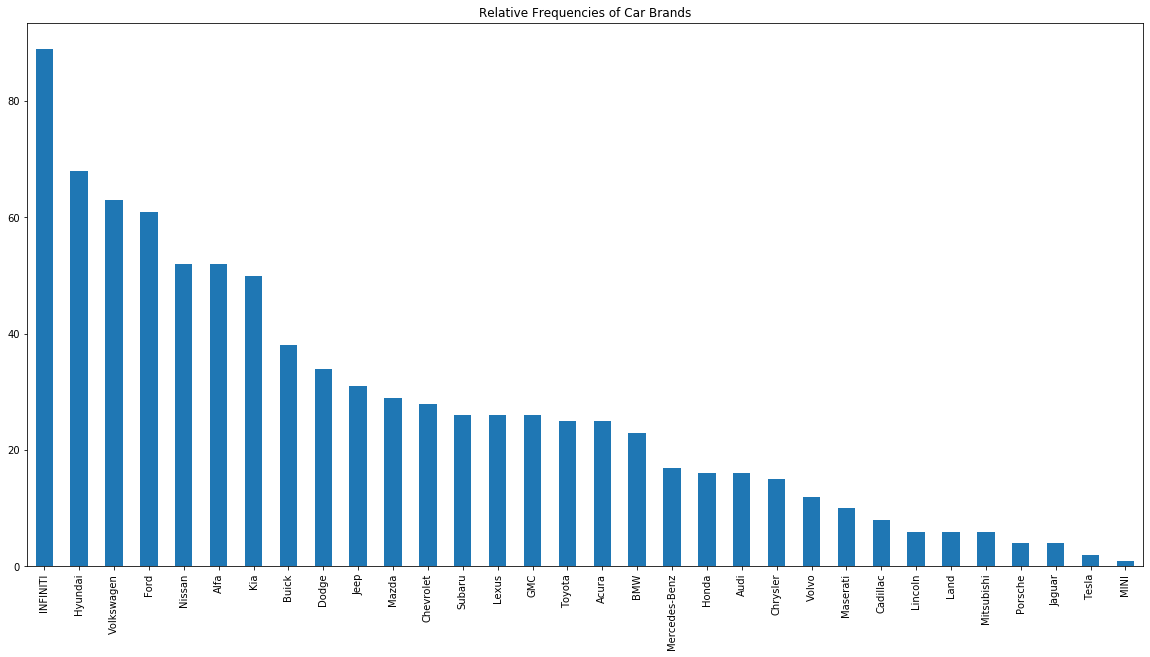

In [188]:
cars['make'].value_counts(normalize=True)
plt.figure(figsize=(20,10))
plt.title("Relative Frequencies of Car Brands")
cars.make.value_counts().plot(kind='bar')

From the above plot, we see that most of the listed cars are made by Infiniti, Hyundai, and Volkswagen. Very few listed cars are made by Mini Cooper, Tesla, and Jaguar.

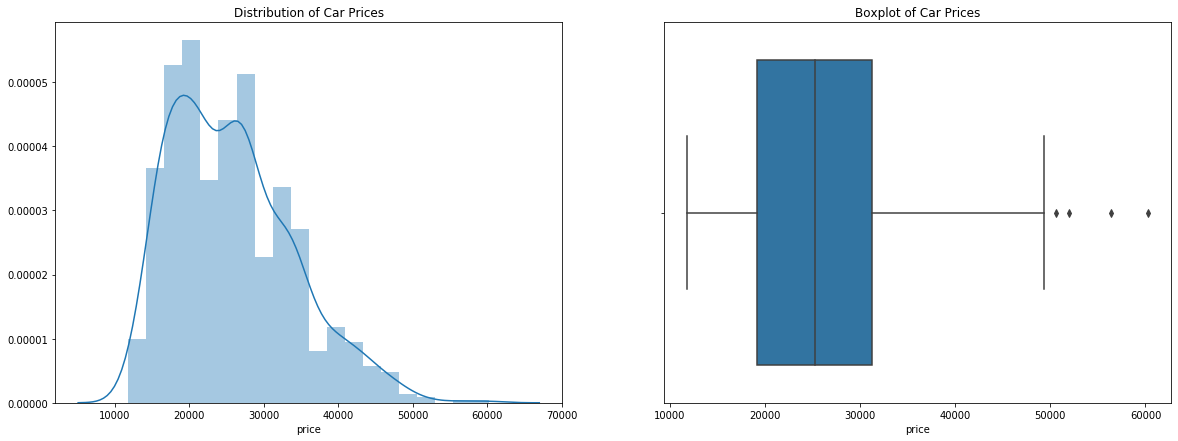

In [189]:
plt.figure(figsize = (20,7))
plt.subplot(1,2,1)
plt.title("Distribution of Car Prices")
sns.distplot(cars.price)
plt.subplot(1,2,2)
plt.title("Boxplot of Car Prices")
sns.boxplot(cars.price)
plt.show()

The above plots give a more visual representation of the distribution of car prices in our dataset. We knew from the description of the dataset above that prices ranged from \$11,790 to \$60,270, with a median of \$25,250. 

The graph on the left shows that prices are bimodal and right skewed, evident from the two peaks and the long right tail. This means that the average price is higher than the mode or median -- being influenced by extremely high price values. 
Thus, most cars are not around \$25,000, but rather are ~\$19,000 or ~\$26,000. 

Evidence of outlier prices is supported by the boxplot on the right, where cars costing more than ~\$50,000 are deviant from the majority of cars. 

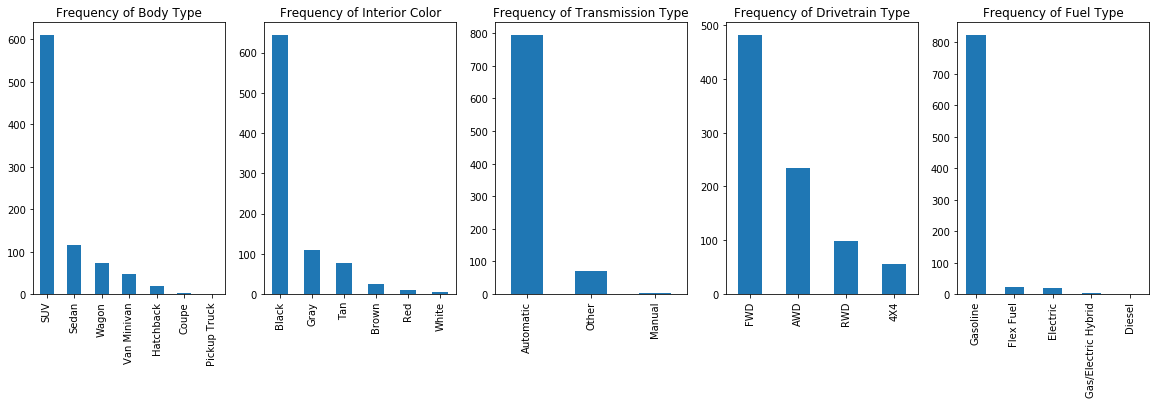

In [190]:
#exploring categorical variables
plt.figure(figsize = (20,5))
plt.subplot(1,5,1)
plt.title("Frequency of Body Type")
cars.body.value_counts().plot(kind='bar')
plt.subplot(1,5,2)
plt.title("Frequency of Interior Color")
cars.interior.value_counts().plot(kind='bar')
plt.subplot(1,5,3)
plt.title("Frequency of Transmission Type")
cars.tm.value_counts().plot(kind='bar')
plt.subplot(1,5,4)
plt.title("Frequency of Drivetrain Type")
cars.drive.value_counts().plot(kind='bar')
plt.subplot(1,5,5)
plt.title("Frequency of Fuel Type")
cars.fuel.value_counts().plot(kind='bar')
plt.show()

The above count plots give more insight to the categorical, or non-numeric variables in our data.

At a glance, it is evident that most of our cars are SUVs with automatic transmissions, front-wheel drive, and run on gasoline.

This helps establish the base group of our dummy variables, which will be made prior to model construction.


To recap, the typical car in our dataset is a 2019 Infiniti SUV, with ~28k miles, 1 previous owner, and a price tag of around \$19k or \$26k.
The car has a black interior, automatic transmission, FWD, and runs on gas.

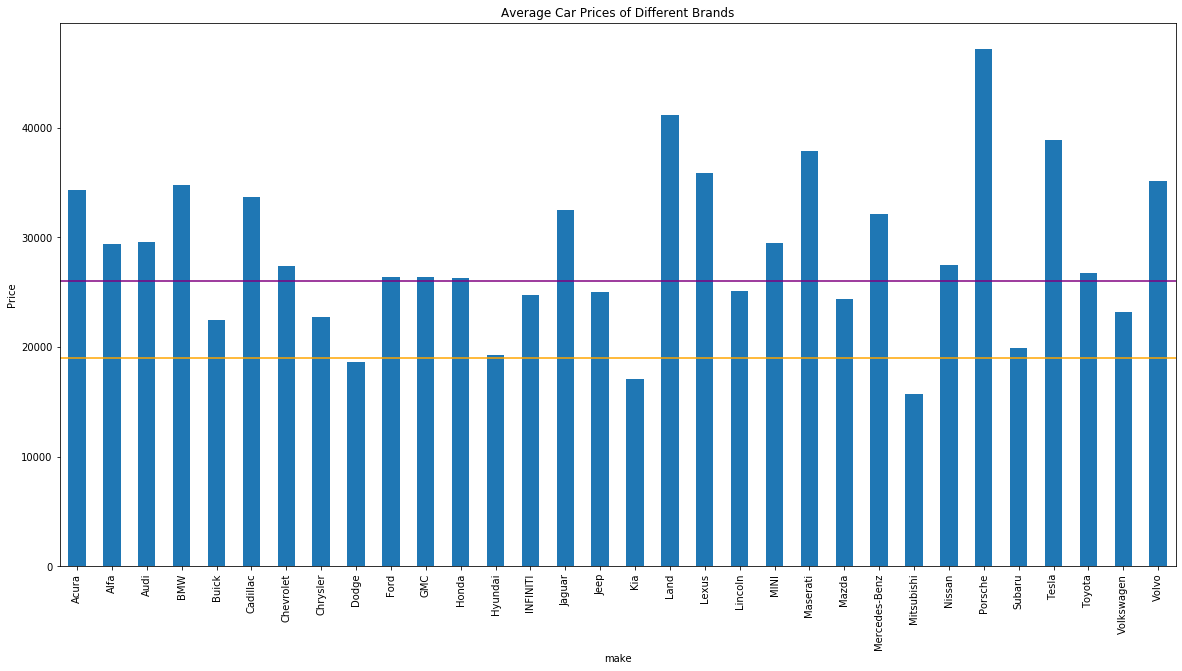

In [198]:
plt.figure(figsize = (20,10))
plt.title("Average Car Prices of Different Brands")
plt.ylabel("Price")
cars.groupby('make').mean().price.plot(kind="bar")
#~$19,000 or ~$27,000 averages
plt.axhline(y=19000,color="orange") 
plt.axhline(y=26000,color="purple")
plt.show()

This plot gives a visual overview of the mean prices of different brands. We see that Porsche and Land Rover have the highest priced cars, and may be responsible for the outliers and skew seen earlier. 

The purple line is set at \$26,000 and the orange line is set at \$19,000. These lines confirm what the distribution plot of prices earlier showed -- two modes of car prices exist in this dataset. We see Chevrolet, Ford, GMC, and many other brands have an average price of around \$26,000. At the same time, brands like Dodge, Hyundai, and Subaru are priced around \$19,000.

In [203]:
#making dummy var's
dummy = pd.get_dummies(cars[['body','interior','tm','drive','fuel']])
carsd = cars.merge(dummy,left_index=True,right_index=True)
carsd = carsd.drop(['make','body','interior','exterior','tm','drive','fuel'],1)
#setting base variables
#body = SUV
#interior = black
#transmission = automatic
#drive = FWD
#fuel = gasoline
carsd = carsd.drop(['body_SUV','interior_Black','tm_Automatic','drive_FWD','fuel_Gasoline'],1)
carsd.to_csv('cars.csv',index=False,header=True)
carsd.head(10)

,year,miles,price,owners,hp,torque,height,length,width,gclear,...,interior_White,tm_Manual,tm_Other,drive_4X4,drive_AWD,drive_RWD,fuel_Diesel,fuel_Electric,fuel_Flex Fuel,fuel_Gas/Electric Hybrid
0,2016,25357,18400,1,185,181,64.7,179.4,71.6,6.3,...,0,0,0,0,0,0,0,0,0,0
1,2017,21296,27500,1,295,270,68.6,200.1,77.2,6.5,...,0,0,1,0,0,0,0,0,0,0
2,2018,16428,16600,1,138,148,65.3,168.4,69.9,6.2,...,0,0,0,0,0,0,0,0,0,0
3,2018,14324,16700,1,125,115,62.4,169.1,69.3,7.0,...,0,0,0,0,0,0,0,0,0,0
4,2016,49463,21000,2,280,310,70.0,198.3,90.2,7.8,...,0,0,0,0,0,0,0,0,0,0
5,2017,21265,28280,1,235,258,64.8,182.3,83.9,6.9,...,0,0,0,0,0,0,0,0,0,0
6,2020,1390,23980,1,174,206,58.0,193.6,72.2,5.4,...,0,0,0,0,0,0,0,0,0,0
7,2019,9819,39900,1,248,258,58.2,194.6,83.7,5.7,...,0,0,0,0,0,1,0,0,0,0
8,2019,9194,20140,1,283,260,69.0,203.7,88.5,5.8,...,0,0,0,0,0,0,0,0,1,0
9,2017,15898,18000,1,192,271,57.5,191.1,73.2,5.1,...,0,0,0,0,0,0,0,0,0,1


The dataframe used for modeling is created above. Dummy variables are created for our categorical variables, creating new columns in the dataframe for each level in the original variable. Not every level, or category needs a column to fully represent each categorical variable by establishing the baseline categories. By doing so, the model will effectively capture the effect of the difference between the levels -- between gasoline and diesel cars for instance.
The baselines are taken as:

Body: SUV
Interior Color: Black
Transmission: Automatic
Drivetrain: FWD
Fuel: Gasoline

The original categorical variables are then dropped from the dataset, completing the switch. The resulting dataframe is exported to a CSV file, from which data analysis can be done.